In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import random
import pickle as pkl
import igraph as ig
import hypernetx as hnx
import xgi
import copy

# Python files
import sys
sys.path.insert(1,'../')
import simplicial as sr
import Hypergraph_Models as hm
import Hypergraph_Functions as hf
import Hypergraph_Processes as hp


# Diffusion function

In [2]:
def diffusion(w,E,epsilon,slice=1,want='numbers'):
    uniform = [sum(w.values())/len(w)]*len(w)
    distance = sp.stats.wasserstein_distance(list(w.values()),uniform)
    results = {}
    if want=='numbers':
        results[0] = distance
    else:
        results[0] = w.copy()
    round = 0
    if type(epsilon) is int:
        for i in range(epsilon-1):
            chosen_edges = random.choices(E,k=slice)
            for e in chosen_edges:
                try:
                    new_weight = sum(w[v] for v in set(e))/len(set(e))
                except:
                    print('found vertex with no weight')
                    print(e)
                    print(set(e).intersection(set(w.keys())))
                for v in set(e):
                    w[v] = new_weight
            distance = sp.stats.wasserstein_distance(list(w.values()),uniform)
            round += slice
            if want=='numbers':
                results[round] = distance
            else:
                results[round] = w.copy()
    else:
        while distance>epsilon:
            chosen_edges = random.choices(E,k=slice)
            for e in chosen_edges:
                new_weight = sum(w[v] for v in set(e))/len(set(e))
                for v in set(e):
                    w[v] = new_weight
            distance = sp.stats.wasserstein_distance(list(w.values()),uniform)
            round += slice
            if want=='numbers':
                results[round] = distance
            else:
                results[round] = w.copy()
    return results

# Getting and cleaning all of the datasets

In [184]:
filenames = [
    "contact-primary-school", 
    "contact-high-school", 
    "hospital-lyon", 
    "email-enron", 
    "email-eu", 
    "diseasome", 
    "disgenenet", 
    "ndc-substances", 
    "congress-bills", 
    "tags-ask-ubuntu",
]

datasets = {}
vertex_data = {}
edge_data = {}
for filename in filenames:
    H = xgi.load_xgi_data(filename)
    E = list(set([tuple(sorted(e)) for e in H.edges.members() if len(e)<=11 and len(e)>=2])) ## changed 11 to 5
    E = [set(e) for e in E]
    V = list(set([i for e in E for i in e]))
    
    #For ask-ubuntu, we make two smaller graphs
    #One only keeps the first 20000 edges
    #The other throws away half of the vertices
    if filename == "tags-ask-ubuntu": 
        #Edge-chopped version
        V_1 = V.copy()
        E_1 = E[:20000]
        V_1,E_1 = hf.giant_component(V_1,E_1)
        datasets["ubuntu (edge-chopped)"] = (V_1,E_1)
        vertex_data["ubuntu (edge-chopped)"] = len(V_1)
        edge_data["ubuntu (edge-chopped)"] = len(E_1)

        #Vertex-chopped version
        V_2 = []
        for v in V:
            if random.choice([1,2])==1:
                V_2.append(v)
        #We use the strict definition of induced subgraph
        E_2 = []
        for e in E:
            accept = True
            for v in e:
                if v not in V_2:
                    accept = False
                    break
            if accept:
                E_2.append(e)
        V_2,E_2 = hf.giant_component(V_2,E_2)
        datasets["ubuntu (vertex-chopped)"] = (V_2,E_2)
        vertex_data["ubuntu (vertex-chopped)"] = len(V_2)
        edge_data["ubuntu (vertex-chopped)"] = len(E_2)
    #All other datasets are built normally
    else:
        V,E = hf.giant_component(V,E)
        datasets[filename] = (V,E)
        vertex_data[filename] = len(V)
        edge_data[filename] = len(E)

df = pd.DataFrame({'n': vertex_data.copy(), 'm': edge_data.copy()})

Verifying that all of the datasets are built correctly

In [185]:
for name in datasets.keys():
    print(name)
    print('|V| = {0}, |E| = {1}\n'.format(len(datasets[name][0]),len(datasets[name][1])))

contact-primary-school
|V| = 242, |E| = 12704

contact-high-school
|V| = 327, |E| = 7818

hospital-lyon
|V| = 75, |E| = 1824

email-enron
|V| = 143, |E| = 1442

email-eu
|V| = 967, |E| = 23729

diseasome
|V| = 516, |E| = 314

disgenenet
|V| = 1799, |E| = 692

ndc-substances
|V| = 2348, |E| = 4559

congress-bills
|V| = 1715, |E| = 58788

ubuntu (edge-chopped)
|V| = 2520, |E| = 19999

ubuntu (vertex-chopped)
|V| = 1272, |E| = 12477



# Setting parameters for all experiments

In [186]:
#Whether or not we include multisets should be consistent across all experiments
multisets = False
skeleton = True

#The number of samples for each experiment will be different
#For example: adversarial growth takes forever so should only be run a few times
rolls = {
    'random growth': 100,
    'adversarial growth': 20,
    'single-source diffusion': 100,
    '10% sprinkled diffusion': 100,
}

# Getting the fitted parameters

In [187]:
d = {}
m = {}

for name in datasets.keys():
    V,E = datasets[name]

    #####
    # d #
    #####
    d[name] = hf.degrees(V,E)

    #####
    # m #
    #####
    E_sorted = hf.sort_edges(E)
    m[name] = {}
    for k in E_sorted.keys():
        m[name][k] = len(E_sorted[k])

In [188]:
def q_fit(E, d, m, multisets=False, skeleton=True, num_cl_samples=10, num_iterations=10):
    sr_data = sr.Simplicial(E)._simplicial_pairs()
    num_pairs = sr_data[0] + sr_data[1]
    q = 0.5
    delta = 0.5
    for i in range(num_iterations):
        delta = delta/2
        q_pairs = 0
        for j in range(num_cl_samples):
            E_q = hm.simplicial_chung_lu(d, m, q, multisets=multisets, skeleton=skeleton)
            q_data = sr.Simplicial(E_q)._simplicial_pairs()
            q_pairs += q_data[0] + q_data[1]
        q_pairs = q_pairs/num_cl_samples
        if q_pairs > num_pairs:
            q = q - delta
        else:
            q = q + delta
    return q, q_pairs

In [189]:
## getting the 'best' q parameters
fitted_q_values = {}
for name in datasets.keys():
    fitted_q_values[name] = q_fit(datasets[name][1], d[name], m[name])
    sr_data = sr.Simplicial(datasets[name][1])._simplicial_pairs()
    num_pairs = sr_data[0] + sr_data[1]
    print(name, fitted_q_values[name], num_pairs)

contact-primary-school (0.51513671875, 15988.2) 16199
contact-high-school (0.54345703125, 8068.1) 7942
hospital-lyon (0.00048828125, 2592.3) 2507
email-enron (0.86865234375, 4987.8) 5094
email-eu (0.90478515625, 119639.9) 117504
diseasome (0.47119140625, 41.4) 34
disgenenet (0.33544921875, 118.5) 122
ndc-substances (0.64990234375, 6484.9) 6509
congress-bills (0.88720703125, 262397.9) 258133
ubuntu (edge-chopped) (0.00048828125, 14152.9) 10609
ubuntu (vertex-chopped) (0.12939453125, 23604.9) 23435


## New stuff

In [180]:
df = pd.DataFrame({'n': vertex_data.copy(), 'm': edge_data.copy()})

In [181]:
#This is what will get added to the dataframe
experiment_mean = {}
experiment_stdv = {}

#Parameters were set at the beginning
num_rolls = rolls['random growth']

for name in datasets.keys():
    V,E = datasets[name]
    results = hp.giant_component_growth(V, E)
    for j in results:
        results[j] = [results[j]]
    for i in range(num_rolls - 1):
        sample = hp.giant_component_growth(V, E)
        for j in results.keys():
            results[j].append(sample[j])
        ## compute and store mean and stdv
        results_mean = {}
        results_stdv = {}
        for i in results.keys():
            results_mean[i] = np.mean(results[i])
            results_stdv[i] = np.std(results[i])
    experiment_mean[name] = results_mean.copy()
    experiment_stdv[name] = results_stdv.copy()

    ## next, try q = 0, 1 and fitted value
    q_list = [0, float(np.round(fitted_q_values[name][0], decimals=4)), 1]
    for q in q_list: 
        E = hm.simplicial_chung_lu(d[name], m[name], q, multisets=multisets, skeleton=skeleton)
        results = hp.giant_component_growth(V,E)
        for j in results:
            results[j] = [results[j]]
        for i in range(num_rolls-1):
            E = hm.simplicial_chung_lu(d[name], m[name], q, multisets=multisets, skeleton=skeleton)
            sample = hp.giant_component_growth(V,E)
            for j in results.keys():
                results[j].append(sample[j])
        ## compute and store mean and stdv
        results_mean = {}
        results_stdv = {}
        for i in results.keys():
            results_mean[i] = np.mean(results[i])
            results_stdv[i] = np.std(results[i])
        experiment_mean['{0} (q={1})'.format(name, q)] = results_mean.copy()
        experiment_stdv['{0} (q={1})'.format(name, q)] = results_stdv.copy()
                
# Saving to the dataframe
df_m = pd.DataFrame({'random growth mean':experiment_mean.copy()})
df_s = pd.DataFrame({'random growth stdv':experiment_stdv.copy()})
df = pd.concat([df,df_m,df_s],axis=1)

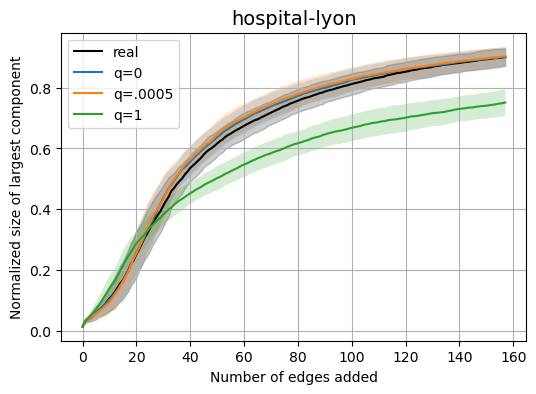

In [183]:
## sanity check - plot one dataset

#dataset = 'email-enron'
dataset = 'hospital-lyon'

n = int(df['n'][dataset])
stop_value = 0.9*n
c = 0
while True:
    if df['random growth mean'][dataset][c] < stop_value:
        c += 1
    else:
        break
cutoff = c+1

plt.figure(figsize=(6,4))

_m = df['random growth mean'][dataset]
_s = df['random growth stdv'][dataset]
plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='real', color='black')
plt.fill_between(list(_m.keys())[:cutoff], 
                 np.array([i/n for i in _m.values()][:cutoff])-np.array([i/n for i in _s.values()][:cutoff]),
                 np.array([i/n for i in _m.values()][:cutoff])+np.array([i/n for i in _s.values()][:cutoff]),
                 alpha=.2, color='black'
                )

_m = df['random growth mean'][dataset+' (q=0)']
_s = df['random growth stdv'][dataset+' (q=0)']
plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=0')
plt.fill_between(list(_m.keys())[:cutoff], 
                 np.array([i/n for i in _m.values()][:cutoff])-np.array([i/n for i in _s.values()][:cutoff]),
                 np.array([i/n for i in _m.values()][:cutoff])+np.array([i/n for i in _s.values()][:cutoff]),
                 alpha=.2
                )
## best case
best = [x for x in df['random growth mean'].keys() if 'q=0.' in x][0]
_m = df['random growth mean'][best]
_s = df['random growth stdv'][best]
plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q='+best[-6:-1])
plt.fill_between(list(_m.keys())[:cutoff], 
                 np.array([i/n for i in _m.values()][:cutoff])-np.array([i/n for i in _s.values()][:cutoff]),
                 np.array([i/n for i in _m.values()][:cutoff])+np.array([i/n for i in _s.values()][:cutoff]),
                 alpha=.2
                )

_m = df['random growth mean'][dataset+' (q=1)']
_s = df['random growth stdv'][dataset+' (q=1)']
plt.plot(list(_m.keys())[:cutoff], [i/n for i in _m.values()][:cutoff], label='q=1')
plt.fill_between(list(_m.keys())[:cutoff], 
                 np.array([i/n for i in _m.values()][:cutoff])-np.array([i/n for i in _s.values()][:cutoff]),
                 np.array([i/n for i in _m.values()][:cutoff])+np.array([i/n for i in _s.values()][:cutoff]),
                 alpha=.2
                )
plt.title(dataset, fontsize=14)
plt.xlabel('Number of edges added')
plt.ylabel('Normalized size of largest component')
plt.grid()
plt.legend();


'0.872'

In [91]:
df

,n,m,random growth mean,random growth stvd
email-enron,143.0,1442.0,"{0: 1.0, 1: 3.1, 2: 3.94, 3: 4.64, 4: 5.23, 5:...","{0: 0.0, 1: 1.5329709716755893, 2: 2.014050644..."
email-enron (q=0),NaN,NaN,"{0: 1.0, 1: 2.88, 2: 3.68, 3: 4.35, 4: 5.14, 5...","{0: 0.0, 1: 1.2270289320142374, 2: 2.009378013..."
email-enron (q=0.872),NaN,NaN,"{0: 1.0, 1: 3.2, 2: 4.08, 3: 5.05, 4: 5.79, 5:...","{0: 0.0, 1: 1.7549928774784243, 2: 2.360847305..."
email-enron (q=1),NaN,NaN,"{0: 1.0, 1: 3.27, 2: 4.39, 3: 5.36, 4: 6.18, 5...","{0: 0.0, 1: 2.115915877344844, 2: 2.8421646679..."


In [94]:
df['email-enron']['random growth mean']

KeyError: 'email-enron'

TypeError: 'Axes' object is not subscriptable

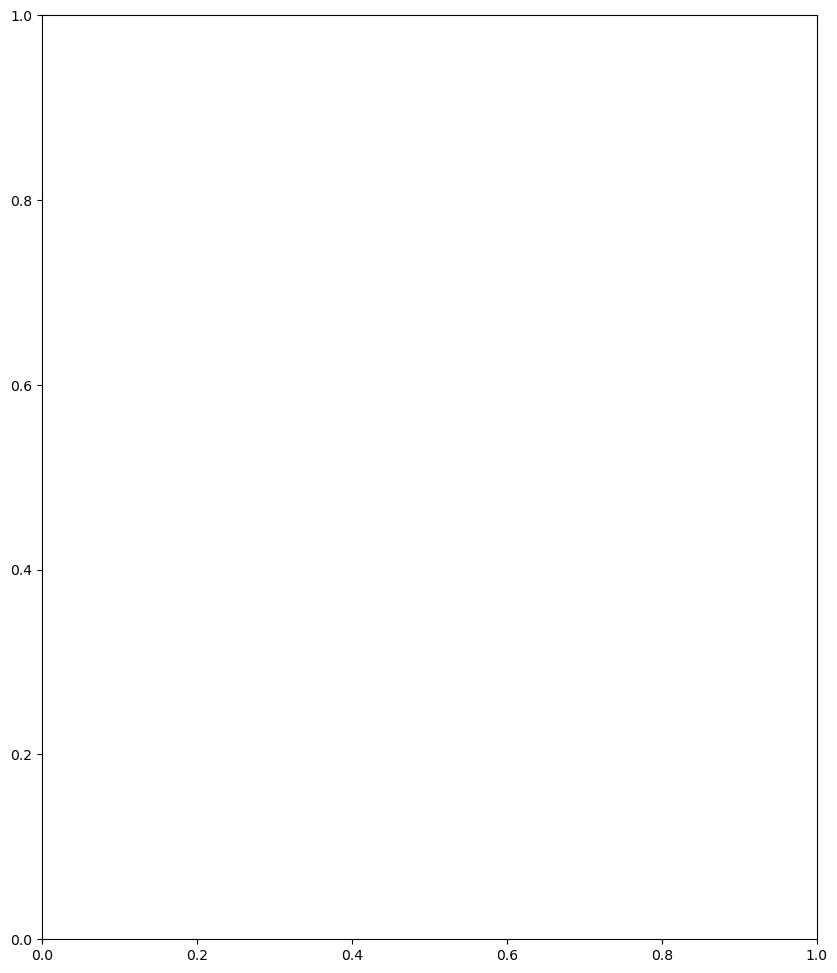

In [88]:
experiments = [
    "random growth",
]
names = 

for i, experiment in enumerate(experiments):
    fig, axs = plt.subplots(1, 1, figsize = (10,12))
    row = 0
    col = 0
    for name in names: 
        if i<1:
            axs[row, col].plot(list(df[experiment][name].keys())[:cutoff[name][experiment]], 
                               [x/n[name] for x in df[experiment][name].values()][:cutoff[name][experiment]], 
                               label='Real', 
                               linewidth=2, 
                               color='black'
                              )
    #        plt.plot(df[experiment]['{0} (Chung-Lu)'.format(name)].keys(),df[experiment]['{0} (Chung-Lu)'.format(name)].values(),label='Chung-Lu')
            axs[row, col].plot(list(df[experiment]['{0} (q=0)'.format(name)].keys())[:cutoff[name][experiment]], 
                               [x/n[name] for x in df[experiment]['{0} (q=0)'.format(name)].values()][:cutoff[name][experiment]],
                               label='q=0'
                              )
            axs[row, col].plot(list(df[experiment]['{0} (q=0.5)'.format(name)].keys())[:cutoff[name][experiment]], 
                               [x/n[name] for x in df[experiment]['{0} (q=0.5)'.format(name)].values()][:cutoff[name][experiment]], 
                               label='q=0.5')
            axs[row, col].plot(list(df[experiment]['{0} (q=1)'.format(name)].keys())[:cutoff[name][experiment]], 
                               [x/n[name] for x in df[experiment]['{0} (q=1)'.format(name)].values()][:cutoff[name][experiment]], 
                               label='q=1')
    #        plt.plot(df[experiment]['{0} (bottom-up)'.format(name)].keys(),df[experiment]['{0} (bottom-up)'.format(name)].values(),label='Bottom-up simplicial')
    #        plt.plot(df[experiment]['{0} (top-down)'.format(name)].keys(),df[experiment]['{0} (top-down)'.format(name)].values(),label='Top-down simplicial')            
        if row == 0 and col == 0:
            axs[row, col].legend()
        if col == 0:
            if i<1:
                axs[row, col].set_ylabel('Normalized size of largest component')
            else:
                axs[row, col].set_ylabel('Wasserstein distnace')
        if row == 2:
            if i<1:
                axs[row, col].set_xlabel('Number of edges added')
            else:
                axs[row, col].set_xlabel('Round')
        axs[row, col].set_title('{0}'.format(name))
        if col == 1:
            col = 0
            row += 1
        else:
            col += 1
    plt.show()
    #fig.savefig('pictures/first-six-{0}.png'.format(experiment))
    plt.close()

## end new stuff

# Experiment 1: random growth
We start at round 0 with no edges and a max component size of 1

On round i+1, we choose a random edge (not already added) and add it to the graph, then track the max component size

We save the data as the dictionary (round -> size of giant)

In [15]:
#This is what will get added to the dataframe
experiment = {}

#Parameters were set at the beginning
num_rolls = rolls['random growth']


# limited_names = [
#     "hospital-lyon", 
#     "disgenenet", 
# ]

for name in datasets.keys():
    V,E = datasets[name]
    results = hp.giant_component_growth(V, E)
    for i in range(num_rolls - 1):
        sample = hp.giant_component_growth(V, E)
        for j in results.keys():
            results[j] += sample[j]
    for j in results.keys():
        results[j] = results[j]/num_rolls
    experiment[name] = results.copy()

    ## TODO: change to bisection
    for q in q_list: 
        E = hm.simplicial_chung_lu(d[name], m[name], q, multisets=multisets, skeleton=skeleton)
        results = hp.giant_component_growth(V,E)
        for i in range(num_rolls-1):
            E = hm.simplicial_chung_lu(d[name], m[name], q, multisets=multisets, skeleton=skeleton)
            sample = hp.giant_component_growth(V,E)
            for j in results.keys():
                results[j] += sample[j]
        ## TODO: keep all so we can compute error bars
        for j in results.keys():
            results[j] = results[j]/num_rolls
    
        #Saving the results
        experiment['{0} (q={1})'.format(name, q)] = results.copy()

#Saving to the dataframe
df_add = pd.DataFrame({'random growth':experiment.copy()})
df = pd.concat([df,df_add],axis=1)

Verifying that the experiment was compiled correctly

In [16]:
df

,n,m,random growth,random growth
email-enron,143.0,1442.0,"{0: 1.0, 1: 3.07, 2: 3.79, 3: 4.58, 4: 5.26, 5...","{0: 1.0, 1: 3.02, 2: 3.59, 3: 4.1, 4: 4.68, 5:..."
email-enron (q=0),NaN,NaN,"{0: 1.0, 1: 2.52, 2: 3.48, 3: 4.38, 4: 5.47, 5...","{0: 1.0, 1: 3.01, 2: 3.85, 3: 4.64, 4: 5.33, 5..."
email-enron (q=0.5),NaN,NaN,"{0: 1.0, 1: 2.98, 2: 3.73, 3: 4.35, 4: 4.93, 5...","{0: 1.0, 1: 3.06, 2: 4.17, 3: 5.17, 4: 5.99, 5..."
email-enron (q=1),NaN,NaN,"{0: 1.0, 1: 3.22, 2: 3.71, 3: 4.56, 4: 5.81, 5...","{0: 1.0, 1: 2.87, 2: 4.1, 3: 5.18, 4: 6.17, 5:..."


In [17]:
with open('fixed_experiments.pkl','wb') as file:
    pkl.dump(df, file)

# Experiment 2: adversarial growth
From the input graph, we compute the betweenness value of each edge

We start at round 0 with no edges and a max component size of 1

At round i+1, we pick the edge with smallest betweenness from the set of edges not chosen yet and add it to the graph, tracking the size of the giant

We save the data as the dictionary (round -> size of giant)

In [18]:
##
#Francois' speed-up, (thanks for this!)
##

#Simple function to reorder edges by betweenness
#Smallest to largest
def reorder_by_betweenness_fast(edges):
    E = edges.copy()
    G = hnx.Hypergraph(E)
    LG = G.get_linegraph()
    g = ig.Graph.from_networkx(LG)
    bet_ig = g.betweenness()
    n = g.vcount()
    norm = 2/((n-1)*(n-2))
    betweenness = dict(zip(g.vs['_nx_name'],[x*norm for x in bet_ig])) 
    E_arranged = list(sorted(betweenness, key=betweenness.get))
    E = [E[i] for i in E_arranged]
    return E

In [19]:
##
#Now the experiment
##

#This is what gets added to the dataframe
#Note that I save a copy of 'experiment' to the dataframe, so re-initializing it is fine
experiment = {}

#Parameters were set at the beginning
## num_rolls = rolls['adversarial growth']
num_rolls = 2

for name in datasets.keys():
    V,E = datasets[name]
    E = reorder_by_betweenness_fast(E)
    results = hp.giant_component_growth(V, E, shuffle_edges=False)
    experiment[name] = results.copy()

    ## TODO: same as #1
    for q in q_list: 
        E = hm.simplicial_chung_lu(d[name], m[name], q, multisets=multisets, skeleton=skeleton)
        E = reorder_by_betweenness_fast(E)
        results = hp.giant_component_growth(V, E, shuffle_edges=False)
        for i in range(num_rolls-1):
            E = hm.simplicial_chung_lu(d[name], m[name], q, multisets=multisets, skeleton=skeleton)
            E = reorder_by_betweenness_fast(E)
            sample = hp.giant_component_growth(V, E, shuffle_edges=False)
            for j in results.keys():
                results[j] += sample[j]
        ## TODO: same as #1
        for j in results.keys():
            results[j] = results[j]/num_rolls
    
        #Saving the results
        experiment['{0} (q={1})'.format(name, q)] = results.copy()
    
    
#Saving to the dataframe
df_add = pd.DataFrame({'adversarial growth':experiment.copy()})
df = pd.concat([df,df_add],axis=1)

In [20]:
#Sanity check
df

,n,m,random growth,random growth,adversarial growth
email-enron,143.0,1442.0,"{0: 1.0, 1: 3.07, 2: 3.79, 3: 4.58, 4: 5.26, 5...","{0: 1.0, 1: 3.02, 2: 3.59, 3: 4.1, 4: 4.68, 5:...","{0: 1, 1: 2, 2: 2, 3: 3, 4: 5, 5: 6, 6: 6, 7: ..."
email-enron (q=0),NaN,NaN,"{0: 1.0, 1: 2.52, 2: 3.48, 3: 4.38, 4: 5.47, 5...","{0: 1.0, 1: 3.01, 2: 3.85, 3: 4.64, 4: 5.33, 5...","{0: 1.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.0, 5: 2...."
email-enron (q=0.5),NaN,NaN,"{0: 1.0, 1: 2.98, 2: 3.73, 3: 4.35, 4: 4.93, 5...","{0: 1.0, 1: 3.06, 2: 4.17, 3: 5.17, 4: 5.99, 5...","{0: 1.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.5, 5: 2...."
email-enron (q=1),NaN,NaN,"{0: 1.0, 1: 3.22, 2: 3.71, 3: 4.56, 4: 5.81, 5...","{0: 1.0, 1: 2.87, 2: 4.1, 3: 5.18, 4: 6.17, 5:...","{0: 1.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.0, 5: 3...."


In [21]:
with open('fixed_experiments.pkl','wb') as file:
    pkl.dump(df, file)

# Experiment 3: Single-source diffusion
We start with a weight function with w(v) = 0 for all but one vertex; a random vertex gets w(v) = 1

Each round, we pick an edge and replace the vertex weights by the average

We save the dictionary (round -> wasserstein distance between w and uniform)

The first time we run the experiment, we run until the distance is < 1/(20|V|) and we record the number of rounds this took

Then we run every other sample for the recorded number of rounds 

In [22]:
#This is what gets added to the dataframe
#Note that I save a copy of 'experiment' to the dataframe, so re-initializing it is fine
experiment = {}
        
#Parameters were set at the beginning
num_rolls = rolls['single-source diffusion']


for name in datasets.keys():
    V, E = datasets[name]

    #s determines how often the wasserstein distance is computed
    s = 10

    #Weight function
    w = {v: 0 for v in V}
    #a random node gets weight 1
    w[random.choice(V)] = 1   
    results = diffusion(w, E, 1/(20*len(V)), slice=s)

    #Record the length of the experiment and fix it for the rest
    first_len = len(results)
    for i in range(num_rolls-1):
        w = {v:0 for v in V}
        w[random.choice(V)] = 1
        sample = diffusion(w, E, first_len, slice=s)
        for j in results.keys():
            results[j] += sample[j]
    for j in results.keys():
        results[j] = results[j]/num_rolls

    #Saving
    experiment[name] = results.copy()

    ## TODO: same as #1
    for q in q_list:
        E_bu = hm.simplicial_chung_lu(d[name], m[name], q, multisets=multisets, skeleton=skeleton)
        
        w = {v: 0 for v in V}
        w[random.choice(V)] = 1   
        results = diffusion(w, E_bu, first_len, slice=s)
        for i in range(num_rolls-1):
            E_bu = hm.simplicial_chung_lu(d[name], m[name], q, multisets=multisets, skeleton=skeleton)
            w = {v:0 for v in V}
            w[random.choice(V)] = 1
            sample = diffusion(w, E_bu, first_len, slice=s)
            for j in results.keys():
                results[j] += sample[j]
        ## TODO: same as #1
        for j in results.keys():
            results[j] = results[j]/num_rolls
    
        #Saving
        experiment['{0} (q={1})'.format(name, q)] = results.copy()
    
#Saving to the dataframe
df_add = pd.DataFrame({'single-source diffusion':experiment.copy()})
df = pd.concat([df,df_add],axis=1)

In [23]:
#Sanity check
df

,n,m,random growth,random growth,adversarial growth,single-source diffusion
email-enron,143.0,1442.0,"{0: 1.0, 1: 3.07, 2: 3.79, 3: 4.58, 4: 5.26, 5...","{0: 1.0, 1: 3.02, 2: 3.59, 3: 4.1, 4: 4.68, 5:...","{0: 1, 1: 2, 2: 2, 3: 3, 4: 5, 5: 6, 6: 6, 7: ...","{0: 0.013888209692405498, 10: 0.01382170277275..."
email-enron (q=0),NaN,NaN,"{0: 1.0, 1: 2.52, 2: 3.48, 3: 4.38, 4: 5.47, 5...","{0: 1.0, 1: 3.01, 2: 3.85, 3: 4.64, 4: 5.33, 5...","{0: 1.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.0, 5: 2....","{0: 0.013888209692405498, 10: 0.01384321971734..."
email-enron (q=0.5),NaN,NaN,"{0: 1.0, 1: 2.98, 2: 3.73, 3: 4.35, 4: 4.93, 5...","{0: 1.0, 1: 3.06, 2: 4.17, 3: 5.17, 4: 5.99, 5...","{0: 1.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.5, 5: 2....","{0: 0.013888209692405498, 10: 0.01377107275009..."
email-enron (q=1),NaN,NaN,"{0: 1.0, 1: 3.22, 2: 3.71, 3: 4.56, 4: 5.81, 5...","{0: 1.0, 1: 2.87, 2: 4.1, 3: 5.18, 4: 6.17, 5:...","{0: 1.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.0, 5: 3....","{0: 0.013888209692405498, 10: 0.01384615384615..."


In [24]:
with open('fixed_experiments.pkl','wb') as file:
    pkl.dump(df, file)

# Experiment 4: 10% sprinkled diffusion
Identical to experiment 3 but 10% of nodes start with w(v) = 1 and we stop when the distance is < 0.005

In both of these experiments, the idea is to reach 5% of the initial distance

In [25]:
#This is what gets added to the dataframe
#Note that I save a copy of 'experiment' to the dataframe, so re-initializing it is fine
experiment = {}

#Parameters were set at the beginning
num_rolls = rolls['10% sprinkled diffusion']

for name in datasets.keys():
    V,E = datasets[name]

    #s determines how often the wasserstein distance is computed
    s = 10

    #Weight function
    w = {v:0 for v in V}
    #10% of nodes get re-weighted
    V_ini = random.sample(V,k=round(len(V)/10))
    for v in V_ini:
        w[v] = 1 
    results = diffusion(w,E,0.005,slice=s)

    #Record the length of the experiment and fix it for the rest
    first_len = len(results)
    
    for i in range(num_rolls-1):
        w = {v:0 for v in V}
        V_ini = random.sample(V,k=round(len(V)/10))
        for v in V_ini:
            w[v] = 1 
        sample = diffusion(w,E,first_len,slice=s)
        for j in results.keys():
            results[j] += sample[j]
    for j in results.keys():
        results[j] = results[j]/num_rolls

    #Saving
    experiment[name] = results.copy()

    ## TODO
    for q in q_list:
        #Bottom-up
        E_bu = hm.simplicial_chung_lu(d[name], m[name], q, multisets=multisets, skeleton=skeleton)
        
        #Weight function
        w = {v:0 for v in V}
        #10% of nodes get re-weighted
        V_ini = random.sample(V,k=round(len(V)/10))
        for v in V_ini:
            w[v] = 1 
        results = diffusion(w, E_bu, first_len, slice=s)
        for i in range(num_rolls-1):
            E_bu = hm.simplicial_chung_lu(d[name], m[name], q, multisets=multisets, skeleton=skeleton)
            #Weight function
            w = {v:0 for v in V}
            #10% of nodes get re-weighted
            V_ini = random.sample(V,k=round(len(V)/10))
            for v in V_ini:
                w[v] = 1 
            sample = diffusion(w, E_bu, first_len, slice=s)
            for j in results.keys():
                results[j] += sample[j]
        ## TODO
        for j in results.keys():
            results[j] = results[j]/num_rolls
    
        #Saving
        experiment['{0} (q={1})'.format(name, q)] = results.copy()
    
#Saving to the dataframe
df_add = pd.DataFrame({'10% sprinkled diffusion':experiment.copy()})
df = pd.concat([df,df_add],axis=1)

In [26]:
%%time
#Sanity check
df

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 6.44 μs


,n,m,random growth,random growth,adversarial growth,single-source diffusion,10% sprinkled diffusion
email-enron,143.0,1442.0,"{0: 1.0, 1: 3.07, 2: 3.79, 3: 4.58, 4: 5.26, 5...","{0: 1.0, 1: 3.02, 2: 3.59, 3: 4.1, 4: 4.68, 5:...","{0: 1, 1: 2, 2: 2, 3: 3, 4: 5, 5: 6, 6: 6, 7: ...","{0: 0.013888209692405498, 10: 0.01382170277275...","{0: 0.1766345542569319, 10: 0.1681107616160065..."
email-enron (q=0),NaN,NaN,"{0: 1.0, 1: 2.52, 2: 3.48, 3: 4.38, 4: 5.47, 5...","{0: 1.0, 1: 3.01, 2: 3.85, 3: 4.64, 4: 5.33, 5...","{0: 1.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.0, 5: 2....","{0: 0.013888209692405498, 10: 0.01384321971734...","{0: 0.1766345542569319, 10: 0.1683120901187835..."
email-enron (q=0.5),NaN,NaN,"{0: 1.0, 1: 2.98, 2: 3.73, 3: 4.35, 4: 4.93, 5...","{0: 1.0, 1: 3.06, 2: 4.17, 3: 5.17, 4: 5.99, 5...","{0: 1.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.5, 5: 2....","{0: 0.013888209692405498, 10: 0.01377107275009...","{0: 0.1766345542569319, 10: 0.1675452922174950..."
email-enron (q=1),NaN,NaN,"{0: 1.0, 1: 3.22, 2: 3.71, 3: 4.56, 4: 5.81, 5...","{0: 1.0, 1: 2.87, 2: 4.1, 3: 5.18, 4: 6.17, 5:...","{0: 1.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.0, 5: 3....","{0: 0.013888209692405498, 10: 0.01384615384615...","{0: 0.1766345542569319, 10: 0.1676916341557951..."


In [27]:
with open('fixed_experiments.pkl','wb') as file:
    pkl.dump(df, file)

In [28]:
with open('fixed_experiments.pkl','rb') as file:
    df = pkl.load(file)
df

,n,m,random growth,random growth,adversarial growth,single-source diffusion,10% sprinkled diffusion
email-enron,143.0,1442.0,"{0: 1.0, 1: 3.07, 2: 3.79, 3: 4.58, 4: 5.26, 5...","{0: 1.0, 1: 3.02, 2: 3.59, 3: 4.1, 4: 4.68, 5:...","{0: 1, 1: 2, 2: 2, 3: 3, 4: 5, 5: 6, 6: 6, 7: ...","{0: 0.013888209692405498, 10: 0.01382170277275...","{0: 0.1766345542569319, 10: 0.1681107616160065..."
email-enron (q=0),NaN,NaN,"{0: 1.0, 1: 2.52, 2: 3.48, 3: 4.38, 4: 5.47, 5...","{0: 1.0, 1: 3.01, 2: 3.85, 3: 4.64, 4: 5.33, 5...","{0: 1.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.0, 5: 2....","{0: 0.013888209692405498, 10: 0.01384321971734...","{0: 0.1766345542569319, 10: 0.1683120901187835..."
email-enron (q=0.5),NaN,NaN,"{0: 1.0, 1: 2.98, 2: 3.73, 3: 4.35, 4: 4.93, 5...","{0: 1.0, 1: 3.06, 2: 4.17, 3: 5.17, 4: 5.99, 5...","{0: 1.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.5, 5: 2....","{0: 0.013888209692405498, 10: 0.01377107275009...","{0: 0.1766345542569319, 10: 0.1675452922174950..."
email-enron (q=1),NaN,NaN,"{0: 1.0, 1: 3.22, 2: 3.71, 3: 4.56, 4: 5.81, 5...","{0: 1.0, 1: 2.87, 2: 4.1, 3: 5.18, 4: 6.17, 5:...","{0: 1.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.0, 5: 3....","{0: 0.013888209692405498, 10: 0.01384615384615...","{0: 0.1766345542569319, 10: 0.1676916341557951..."


In [29]:
t_end = time()
print((t_end - t_start)/60)

1.5669852177302042
